# Modelo para predição do Número de Pessoas Retidas por 30 Dias
- O objetivo do modelo é prever o Número de Pessoas Retidas por 30 Dias com 15 dias de antecedência
- Serão usados dois modelos com princípios diferentes, o intuito é usa-los em conjunto para aumentar a precisão
- Os modelos usados serão: uma Rede Neural Linear e um Gradient Boost (Aumento de Gradiente)
- Serão usadas para controle as métricas: Erro Médio Absoluto (MAE) e Erro Quadrático Médio (MSE) 

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install scikit-optimize
from skopt import gp_minimize, forest_minimize

  </br>

Análisando o objetivo do modelo, foi possível identificar alguns *Outliers*.</br>
Focando especificamente neles, foi constatado que os mesmos representam 6% do objetivo.</br>
Esses *Outliers* são casos positivos em que houve maior retenção que a média.
</br>
</br>

In [ ]:
data = pd.read_csv('/content/retained_bank_organic.csv')
data.shape

(92, 13)

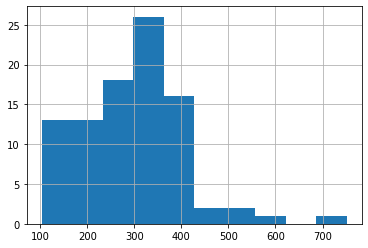

In [ ]:
data['Installers retained for 30 days'].hist()

In [ ]:
target = data[['Installers retained for 30 days']].sort_values('Installers retained for 30 days')
outliers = target[target['Installers retained for 30 days'] > 420]
outliers

,Installers retained for 30 days
59,473
56,486
60,496
77,527
58,600
57,751


In [ ]:
outliers.count()

Installers retained for 30 days    6
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a7d082a90>]],
      dtype=object)

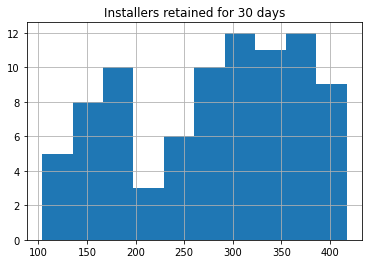

In [ ]:
target[target['Installers retained for 30 days'] < 420].hist()

## Linear Neural Network
O primeiro modelo de Machine Learning</br> 
- A princípio serão usadas todas colunas que teriamos acesso no 15º dia após a instalação. </br>
- Os dados de treino e validação foram transformados em tensores e ajustados para ter as dimensões necessárias.

In [ ]:
X_cols = ['Store Listing Visitors', 'Installers',
          'Visitor-to-Installer conversion rate', 'Installers retained for 1 day',
          'Installer-to-1 day retention rate', 'Installers retained for 7 days',
          'Installer-to-7 days retention rate', 'Installers retained for 15 days',
          'Installer-to-15 days retention rate']

X = data[X_cols]
y = data['Installers retained for 30 days']

In [ ]:
corte = 62
Xtr, Xval  = np.array(X[:corte]), np.array(X[corte:])
ytr, yval = np.array(y[:corte]), np.array(y[corte:])

Xtr.shape, Xval.shape, ytr.shape, yval.shape

((62, 9), (30, 9), (62,), (30,))

In [ ]:
Xtr_t = torch.from_numpy(Xtr).float()
ytr_t = torch.from_numpy(ytr).float().unsqueeze(dim=-1)
Xval_t = torch.from_numpy(Xval).float()
yval_t = torch.from_numpy(yval).float().unsqueeze(dim=-1)

In [ ]:
Xtr_t.shape, ytr_t.shape, Xval_t.shape, yval_t.shape

(torch.Size([62, 9]),
 torch.Size([62, 1]),
 torch.Size([30, 9]),
 torch.Size([30, 1]))

 </br>

- A Rede Neural foi configurada para ter duas camadas ocultas.</br>
- Uma das camadas da Rede Neural fará a normalização dos dados.
- Serão ajustados a *quantidade de nós* em cada camada e a *taxa de aprendizado* para obter maior previsão.

In [ ]:
class LNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super(LNN,self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1)
        self.hidden2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, 1)
        
    def forward(self, x):
        x = F.normalize(x)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)

In [ ]:
def tune_mlp(params):
    torch.manual_seed(0)
    hidden1, hidden2, learning_rate = params
    mdl = LNN(Xtr_t.shape[1], hidden1, hidden2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mdl.parameters(), lr=learning_rate)
    
    for epoch in range(100): 
        optimizer.zero_grad()

        p = mdl(Xtr_t)
        loss = criterion(p, ytr_t)
        loss.backward()
        optimizer.step()
    
    p = mdl(Xval_t).detach().numpy()
    metric = mean_squared_error(yval_t.numpy(), p)
        
    print(params, metric)
    print()
    
    return metric

In [ ]:
space = [(200, 1000),
         (200, 1000),
         (1e-5, 1e-3, 'log-uniform')]

In [ ]:
#res = gp_minimize(tune_mlp, space, random_state=0, verbose=1, n_calls=50, n_random_starts= 20)

 </br>

Os testes foram feitos dividindo os dados em 3 momentos diferentes, para observar como o modelo se comportaria.</br> Após verificar a divisão mais estável, foram escolhidos os parâmetros que serão usados no modelo final.</br></br></br>

62 dias para treino e 30 dias para validação</br>
Parâmetros = [758, 401, 0.0010] - MAE = 77.66036</br>
Parâmetros = [764, 705, 0.0008] - MSE = 8953.833</br></br>

46 dias para treino e 46 dias para validação</br>
Parâmetros = [702, 560, 0.0009] - MAE = 106.713326</br></br>

77 dias para treino 15 dias para validação</br>
Parâmetros = [711, 747, 0.0008] - MAE = 92.69824</br></br></br>

Os parâmetros escolhidos foram = [750, 420, 0.0009]</br>
Eles representam respectivamente: quantidade de nós da primeira camada oculta, quantidade de nós da segunda camada oculta e taxa de aprendizado</br></br>

In [ ]:
torch.manual_seed(0)
hidden1, hidden2, learning_rate = [750, 420, 0.0009]
mdl = LNN(Xtr_t.shape[1], hidden1, hidden2)
criterion = nn.MSELoss()
optimizer = optim.Adam(mdl.parameters(), lr=learning_rate)

for epoch in range(100): 
    optimizer.zero_grad()

    p = mdl(Xtr_t)
    loss = criterion(p, ytr_t)
    loss.backward()
    optimizer.step()

p = mdl(Xval_t).detach().numpy()
MAE = mean_absolute_error(yval_t.numpy(), p)
MSE = mean_squared_error(yval_t.numpy(), p)
print('MAE = %s' % MAE)
print('MSE = %s' % MSE)

MAE = 79.7458
MSE = 9180.007


### Feature Selection

- Após ter ajustado os parâmetros, foi testado se realmennte todas as colunas usadas eram necessárias e benéficas para o modelo.
- Os testes mostraram que somente as colunas *Pessoas Retidas por 7/15 Dias* e *Quantia de Visitantes da Loja* eram benéficas. 

In [ ]:
selected = []

In [ ]:
#best_score = best_score - 1e-4 
best_score = 100
for col in X_cols:
    if col not in selected:
        #print(col)
        X = data[selected+[col]].copy()
        Xtr, Xval  = np.array(X[:corte]), np.array(X[corte:])

        Xtr_t = torch.from_numpy(Xtr).float()
        Xval_t = torch.from_numpy(Xval).float()
    
        torch.manual_seed(0)
        hidden1, hidden2, learning_rate = [750, 420, 0.0009]
        mdl = LNN(Xtr_t.shape[1], hidden1, hidden2)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(mdl.parameters(), lr=learning_rate)
        
        for epoch in range(100): 
            optimizer.zero_grad()

            p = mdl(Xtr_t)
            loss = criterion(p, ytr_t)
            loss.backward()
            optimizer.step()
        
        p = mdl(Xval_t).detach().numpy()
        c = mean_absolute_error(yval_t.numpy(), p)
        #print(c)
        if c < best_score:
            print(col, c)
            best_score = c

Store Listing Visitors 80.703735


In [ ]:
selected = ['Store Listing Visitors', "Installers retained for 15 days", 'Installers retained for 7 days']

### Modelo Final

Dando pouco peso para os *Outliers*, o modelo conseguiu prever a Quantidade de Pessoas Retidas por 30 dias com um erro médio de 9 pessoas.</br>
Agora, dando ênfase para os *Outliers*, o erro médio foi de 95 pessoas.</br>

In [ ]:
X = data[selected].copy()

Xtr, Xval  = np.array(X[:corte]), np.array(X[corte:])

Xtr_t = torch.from_numpy(Xtr).float()
Xval_t = torch.from_numpy(Xval).float()

torch.manual_seed(0)
hidden1, hidden2, learning_rate = [750, 420, 0.0009]
mdl = LNN(Xtr_t.shape[1], hidden1, hidden2)
criterion = nn.MSELoss()
optimizer = optim.Adam(mdl.parameters(), lr=learning_rate)

for epoch in range(100): 
    optimizer.zero_grad()

    p = mdl(Xtr_t)
    loss = criterion(p, ytr_t)
    loss.backward()
    optimizer.step()

p_LNN = mdl(Xval_t).detach().numpy()
MAE = mean_absolute_error(yval_t.numpy(), p_LNN)
MSE = mean_squared_error(yval_t.numpy(), p_LNN)
print('MAE = %s' % MAE)
print('MSE = %s' % MSE)

MAE = 78.348305
MSE = 8926.26


## Grandient Boost - XGBoost </br>
O segundo Modelo de Machine Learning
- Os dados foram novamente separados em treino e validação e não são necessárias novas transformações

In [ ]:
X = data[X_cols]
y = data['Installers retained for 30 days']

In [ ]:
corte = 62
Xtr, Xval  = X[:corte], X[corte:]
ytr, yval = y[:corte], y[corte:]

Xtr.shape, Xval.shape, ytr.shape, yval.shape

((62, 9), (30, 9), (62,), (30,))

In [ ]:
rds = 4
def tune_XGBR(params):
    learning_rate, n_estimators, subsample, colsample_bytree= params

    mdl = XGBRegressor(learning_rate= learning_rate, n_estimators= n_estimators,
                       subsample= subsample, colsample_bytree= colsample_bytree,
                       random_state= rds, n_jobs=-1, objective='reg:squarederror')
    
    mdl.fit(Xtr, ytr)

    p = mdl.predict(Xval)
    metric = mean_absolute_error(yval, p)
    #metric = mean_squared_error(yval, p)

    print(params, metric)
    print()
    
    return metric

In [ ]:
space = [(1e-3, 1e-1, 'log-uniform'), # learning_rate
         (500, 2000),  # n_estimators
         (0.4, 1), # subsample
         (0.6, 1)] # colsample_bytree

In [ ]:
#res = forest_minimize(tune_XGBR, space, random_state=0, n_random_starts=20, n_calls=50, verbose=1)

 </br>

Os testes seguiram os mesmos padrões usados na Rede Neural Linear.</br>

62 dias para treino e 30 dias para validação</br>
Parâmetros = [0.022, 1060, 0.48, 0.67] - MAE = 25.5788*</br>
Parâmetros = [0.005,  605, 0.54, 0.97] - MSE = 1096.4200</br></br>

46 dias para treino e 46 dias para validação</br>
Parâmetros = [0.016, 1256, 0.63, 0.96] - MAE = 33.1658</br>
Parâmetros = [0.022, 1060, 0.48, 0.67] - MSE = 4717.5519</br></br>

77 dias para treino 15 dias para validação</br>
Parâmetros = [0.022, 1316, 0.98, 0.78] - MAE = 15.6785</br>
Parâmetros = [0.075,  703, 0.96, 0.63] - MSE = 371.2921</br></br></br>

Os parâmetros escolhidos foram = [0.02, 1200, 0.55, 0.7]</br>
Eles representam respectivamente: taxa de aprendizado, número de arvores, percentual de linhas usadas por iteração e percentual de colunas usadas por iteração. </br></br>

Mesmo que a menor métrica tenha sido obtida dividindo o os dados em 77/15 dias, os parâmetros escolhidos foram baseados no resultado obtido com 62/30 dias. </br>
O motivo dessa escolha é evitar o *Overfitting* e obter um modelo prático para ser usado no dia-a-dia. </br>


### Seeds Test

- Para testar se os parâmetros escolhidos resultavam em uma previsão robusta, o modelo foi testado com 20 padrões diferentes
- O resultado foi um erro médio variando entre 4 e 5 pessoas com pouca enfase aos *Outliers* e 23 a 30 pessoas com maior enfase aos *Outliers*

In [ ]:
dist_mae = []
dist_mse = []
for rds in range(20):

    learning_rate, n_estimators, subsample, colsample_bytree= [0.02, 1200, 0.55, 0.7]

    mdl = XGBRegressor(learning_rate= learning_rate, n_estimators= n_estimators,
                        subsample= subsample, colsample_bytree= colsample_bytree,
                        random_state= rds, n_jobs=-1, objective='reg:squarederror')

    mdl.fit(Xtr, ytr)

    p = mdl.predict(Xval)
    MAE = mean_absolute_error(yval, p)
    MSE = mean_squared_error(yval, p)
    dist_mae.append(MAE)
    dist_mse.append(MSE)
dist_mae = np.array(dist_mae)
dist_mse = np.array(dist_mse)

print('MAE')
print('Min = {} Max = {}' .format(dist_mae.min(),dist_mae.max() ))
print()
print('MSE')
print('Min = {} Max = {}' .format(dist_mse.min(),dist_mse.max() ))

MAE
Min = 14.259696451822917 Max = 18.574957275390624

MSE
Min = 496.11709671863355 Max = 870.56153077976


### Modelo Final
Dando pouco peso para os *Outliers*, o modelo conseguiu prever a Quantidade de Pessoas Retidas por 30 dias com um erro médio de 5 pessoas.</br>
Agora, dando ênfase para os *Outliers*, o erro médio foi de 28 pessoas.</br>

In [ ]:
rds = 0

learning_rate, n_estimators, subsample, colsample_bytree= [0.02, 1200, 0.55, 0.7]

mdl = XGBRegressor(learning_rate= learning_rate, n_estimators= n_estimators,
                    subsample= subsample, colsample_bytree= colsample_bytree,
                    random_state= rds, n_jobs=-1, objective='reg:squarederror')

mdl.fit(Xtr, ytr)

p_XGB = mdl.predict(Xval)
MAE = mean_absolute_error(yval, p_XGB)
MSE = mean_squared_error(yval, p_XGB)

print('MAE = %s' % MAE)
print('MSE = %s' % MSE)

MAE = 17.619810994466146
MSE = 746.6940543817822


## Ensemble

- Testando os modelos em conjunto, a melhor proporção encontrada foi de 90% Gradient Boost e 10% Rede Neural Linear</br>
- O resultado foi um erro médio de 4 pessoas com pouca enfase aos *Outliers* e 23 pessoas com maior enfase aos *Outliers*</br>

In [ ]:
p_LNN= np.squeeze(p_LNN)
for seed in range(11):
    d = seed/10
    p = (0+d)*p_XGB + (1-d)*p_LNN
    MAE = mean_absolute_error(yval, p)
    MSE = mean_squared_error(yval, p)

    print('{}% XGB - {}% LNN' .format(round(((0+d)*100),0),round(((1-d)*100),0)))
    print('MAE = %s' % round(MAE,2))
    print('MSE = %s' % round(MSE,2))
    print()

0.0% XGB - 100.0% LNN
MAE = 78.35
MSE = 8926.26

10.0% XGB - 90.0% LNN
MAE = 69.53
MSE = 7037.68

20.0% XGB - 80.0% LNN
MAE = 61.18
MSE = 5387.02

30.0% XGB - 70.0% LNN
MAE = 52.83
MSE = 3974.27

40.0% XGB - 60.0% LNN
MAE = 44.49
MSE = 2799.44

50.0% XGB - 50.0% LNN
MAE = 36.15
MSE = 1862.53

60.0% XGB - 40.0% LNN
MAE = 27.87
MSE = 1163.53

70.0% XGB - 30.0% LNN
MAE = 21.17
MSE = 702.45

80.0% XGB - 20.0% LNN
MAE = 17.46
MSE = 479.28

90.0% XGB - 10.0% LNN
MAE = 16.47
MSE = 494.03

100.0% XGB - 0.0% LNN
MAE = 17.62
MSE = 746.69



## Próximos Passos Possíveis
- Adicionar mais camadas à LNN
- Treinar modelos diferentes como um Ensemble de Arvores ou uma Regressão Linear
- Testar outras Redes Neurais
- Testar o modelo no dia-a-dia e com mais dados